<a href="https://colab.research.google.com/github/Silpa12345/Deep_learning/blob/main/ELSUS_Rainfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rasterio rioxarray xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 28.1 MB/s eta 0:00:00


In [20]:
from __future__ import annotations


import os
from dataclasses import dataclass
from typing import Optional, Tuple


import numpy as np
import xarray as xr
import rasterio
import rioxarray as rxr
from rasterio.enums import Resampling
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

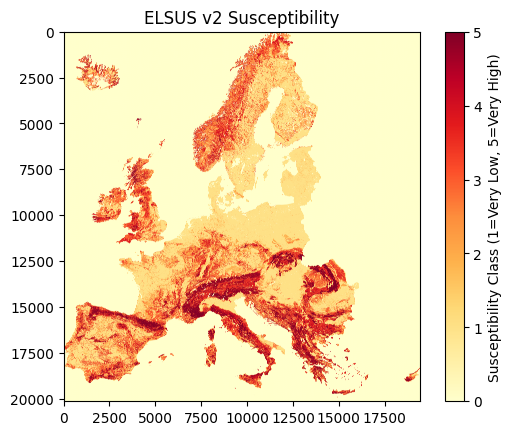

In [21]:
import rasterio
import matplotlib.pyplot as plt

# Load ELSUS susceptibility (ASC format)
elsus_path = "elsus_v2.asc"
base_dir = '/content/drive/MyDrive/Project-Landslide/ELSUS/elsus_v2.asc'
with rasterio.open(base_dir) as src:
    susceptibility = src.read(1)
    profile = src.profile

plt.imshow(susceptibility, cmap="YlOrRd")
plt.colorbar(label="Susceptibility Class (1=Very Low, 5=Very High)")
plt.title("ELSUS v2 Susceptibility")
plt.show()

In [22]:
!pip install h5netcdf

In [23]:
import pandas as pd

# Load GLC CSV (change path)
glc = pd.read_csv("/content/drive/MyDrive/Project-Landslide/ELSUS/nasa_global_landslide_catalog_point.csv")

print(glc.columns.tolist())


['OID', 'source_name', 'source_link', 'event_id', 'event_date', 'event_time', 'event_title', 'event_description', 'location_description', 'location_accuracy', 'landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count', 'storm_name', 'photo_link', 'comments', 'event_import_source', 'event_import_id', 'latitude', 'longitude', 'country_name', 'country_code', 'admin_division_name', 'gazetteer_closest_point', 'gazetteer_distance', 'submitted_date', 'last_edited_date']


In [24]:

# Keep only the necessary columns and rename
glc = glc.rename(columns={"latitude":"lat", "longitude":"lon"})

# Convert date to YYYY-MM-DD
glc["event_date"] = pd.to_datetime(glc["event_date"]).dt.date

# Filter to Europe bounding box (example: lat 35–72, lon -25–45)
europe_glc = glc[(glc["lat"].between(35, 72)) & (glc["lon"].between(-25, 45))].copy()

# Select the required columns
events = europe_glc[["event_id", "event_date", "lat", "lon"]]

# Save as the training CSV
events.to_csv("/content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe.csv", index=False)

print("Saved", len(events), "events for Europe")
print("Total rows:", len(europe_glc))
print("Missing dates (NaT):", europe_glc["event_date"].isna().sum())
s = pd.to_datetime(europe_glc["event_date"], errors="coerce").dropna()
print("Date min:", s.min().date(), "Date max:", s.max().date())
print("Total rows:", len(s))

Saved 1498 events for Europe
Total rows: 1498
Missing dates (NaT): 553
Date min: 1915-12-15 Date max: 2023-08-03
Total rows: 945


In [ ]:
# Mount Drive first if you haven't:
# from google.colab import drive
# drive.mount('/content/drive')

import os

# 1) Write the training script
script_path = "/content/drive/MyDrive/Project-Landslide/ELSUS/train_eu_lhasa2_mode.py"
os.makedirs(os.path.dirname(script_path), exist_ok=True)

with open(script_path, "w") as f:
    f.write("""\
#!/usr/bin/env python3
""" + r"""
""" + """\
\"\"\"
ELSUS-LHASA2 Training Mode: A pragmatic training pipeline inspired by LHASA v2
-------------------------------------------------------------------------------

Goal
----
Train an XGBoost-based daily landslide hazard model for Europe that mimics the
LHASA v2 training concept, using **ELSUS** as a static susceptibility prior.

What this script does
---------------------
1) Builds a training dataset of (cell, date) samples for Europe.
2) Uses **ELSUS** as a static feature and prior; optionally enforces a
   monotonic increase in risk with higher ELSUS category.
3) Ingests dynamic precipitation features (e.g., 1/3/7-day accumulations,
   percent-of-normal, extreme percentiles) from precomputed rasters or NetCDFs.
4) Joins historical landslide events (positives) and generates negatives.
5) Trains an XGBoost classifier, evaluates AUROC/PR-AUC/calibration, and saves
   the model + feature importances + diagnostics.
\"\"\"
from __future__ import annotations

import argparse
import json
import os
from dataclasses import dataclass
from datetime import date, datetime, timedelta
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from dateutil.parser import isoparse
from tqdm import tqdm

import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject

import xarray as xr  # noqa: F401
import rioxarray  # noqa: F401

import geopandas as gpd  # noqa: F401
from shapely.geometry import Point  # noqa: F401

from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

import xgboost as xgb
import joblib  # noqa: F401
import matplotlib.pyplot as plt

# ------------------------------ Config ------------------------------------ #
ELSUS_CLASS_MAP: Dict[int, int] = {
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5,
}

RAIN_FEATURES = ["rain_1d", "rain_3d", "rain_7d"]
OPTIONAL_RAIN_FEATURES = ["rain_anom_7d", "rain_p90_7d"]

MONO_CONSTRAINTS = {
    "elsus_class": +1, "rain_1d": +1, "rain_3d": +1, "rain_7d": +1,
}

RANDOM_STATE = 2025

def daterange(start: date, end: date):
    d = start
    while d <= end:
        yield d
        d += timedelta(days=1)

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

from dataclasses import dataclass
@dataclass
class RasterTemplate:
    width: int
    height: int
    transform: rasterio.Affine
    crs: str
    nodata: Optional[float]

class ELSUSAdapter:
    def __init__(self, elsus_path: str):
        self.elsus_path = elsus_path
        self._read_info()
    def _read_info(self):
        with rasterio.open(self.elsus_path) as src:
            self.crs = src.crs.to_string() if src.crs else "EPSG:4326"
            self.transform = src.transform
            self.width = src.width
            self.height = src.height
            self.nodata = src.nodata
            self.bounds = src.bounds
    def read_classes(self) -> Tuple[np.ndarray, "RasterTemplate"]:
        with rasterio.open(self.elsus_path) as src:
            data = src.read(1)
            data = np.where(np.isfinite(data), data, np.nan)
        recoded = np.full_like(data, np.nan, dtype=float)
        for k, v in ELSUS_CLASS_MAP.items():
            recoded[data == k] = v
        template = RasterTemplate(
            width=self.width, height=self.height, transform=self.transform,
            crs=self.crs, nodata=np.nan,
        )
        return recoded, template

def reproject_to_template(src_path: str, template: "RasterTemplate") -> np.ndarray:
    with rasterio.open(src_path) as src:
        dst_array = np.full((template.height, template.width), np.nan, dtype=np.float32)
        reproject(
            source=rasterio.band(src, 1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=template.transform,
            dst_crs=template.crs,
            resampling=Resampling.bilinear,
        )
        return dst_array

class FeatureAdapter:
    def __init__(self, root: str, template: "RasterTemplate"):
        self.root = root
        self.template = template
    def _path_for(self, name: str, d: date, is_static: bool = False) -> Optional[str]:
        if is_static:
            p = os.path.join(self.root, f"{name}.tif")
            return p if os.path.exists(p) else None
        stamp = d.strftime("%Y%m%d")
        p = os.path.join(self.root, f"{name}_{stamp}.tif")
        return p if os.path.exists(p) else None
    def read_for_date(self, d: date) -> Dict[str, np.ndarray]:
        feats = {}
        for name in RAIN_FEATURES:
            p = self._path_for(name, d)
            if p: feats[name] = reproject_to_template(p, self.template)
        for name in OPTIONAL_RAIN_FEATURES:
            p_daily = self._path_for(name, d)
            p_static = self._path_for(name, d, is_static=True)
            p = p_daily or p_static
            if p: feats[name] = reproject_to_template(p, self.template)
        return feats

@dataclass
class SampleSpec:
    start: date
    end: date
    negative_ratio: float = 3.0
    max_positives_per_day: Optional[int] = None

def load_events_csv(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    for col in ["event_id", "date", "lat", "lon"]:
        if col not in df.columns:
            raise ValueError(f"Missing column '{col}' in events CSV")
    df["date"] = pd.to_datetime(df["date"]).dt.date
    return df

def points_to_rowcol(lons: np.ndarray, lats: np.ndarray, template: "RasterTemplate") -> Tuple[np.ndarray, np.ndarray]:
    inv = ~template.transform
    cols, rows = inv * (lons, lats)
    return rows.astype(int), cols.astype(int)

def mask_invalid_rc(rows: np.ndarray, cols: np.ndarray, template: "RasterTemplate") -> np.ndarray:
    return (rows >= 0) & (rows < template.height) & (cols >= 0) & (cols < template.width)

def build_training_table(events_csv: str, elsus_path: str, rain_root: str, spec: "SampleSpec", out_manifest: Optional[str] = None):
    elsus = ELSUSAdapter(elsus_path)
    elsus_arr, template = elsus.read_classes()
    valid_mask = np.isfinite(elsus_arr)
    ev = load_events_csv(events_csv)
    ev = ev[(ev["date"] >= spec.start) & (ev["date"] <= spec.end)].copy()
    rows, cols = points_to_rowcol(ev["lon"].values, ev["lat"].values, template)
    keep = mask_invalid_rc(rows, cols, template)
    ev = ev.loc[keep].copy()
    ev["row"], ev["col"] = rows[keep], cols[keep]
    ev = ev[valid_mask[ev["row"], ev["col"]]].copy()
    if ev.empty:
        raise ValueError("No events left after filtering to ELSUS footprint and date range.")
    feat_adapter = FeatureAdapter(rain_root, template)
    records = []
    if spec.max_positives_per_day is not None:
        ev = ev.groupby("date", group_keys=False).apply(
            lambda g: g.sample(min(len(g), spec.max_positives_per_day), random_state=RANDOM_STATE)
        )
    valid_idx = np.argwhere(valid_mask)
    for d in tqdm(list(daterange(spec.start, spec.end)), desc="Building samples"):
        day_ev = ev[ev["date"] == d]
        if day_ev.empty and spec.negative_ratio <= 0: continue
        day_feats = feat_adapter.read_for_date(d)
        if not day_feats: continue
        for _, r in day_ev.iterrows():
            r_i, c_i = int(r.row), int(r.col)
            rec = {"date": d.isoformat(), "row": r_i, "col": c_i, "label": 1, "elsus_class": float(elsus_arr[r_i, c_i])}
            for name, arr in day_feats.items():
                val = float(arr[r_i, c_i]) if np.isfinite(arr[r_i, c_i]) else np.nan
                rec[name] = val
            records.append(rec)
        n_pos = len(day_ev)
        n_neg = int(n_pos * spec.negative_ratio)
        if n_neg > 0:
            rng = np.random.default_rng(RANDOM_STATE + int(d.strftime('%Y%m%d')))
            idx = rng.choice(len(valid_idx), size=n_neg, replace=False)
            for k in idx:
                r_i, c_i = valid_idx[k]
                rec = {"date": d.isoformat(), "row": int(r_i), "col": int(c_i), "label": 0, "elsus_class": float(elsus_arr[r_i, c_i])}
                for name, arr in day_feats.items():
                    val = float(arr[r_i, c_i]) if np.isfinite(arr[r_i, c_i]) else np.nan
                    rec[name] = val
                records.append(rec)
    if not records:
        raise RuntimeError("No samples were created. Check date range and feature availability.")
    df = pd.DataFrame.from_records(records)
    core = [c for c in ["rain_1d","rain_3d","rain_7d"] if c in df.columns]
    if core:
        df = df[df[core].notnull().all(axis=1)].reset_index(drop=True)
    if out_manifest:
        ensure_dir(os.path.dirname(out_manifest))
        df.to_parquet(out_manifest, index=False)
    feature_cols = ["elsus_class"] + [c for c in df.columns if c in ["rain_1d","rain_3d","rain_7d","rain_anom_7d","rain_p90_7d"]]
    return df, template, feature_cols

def train_model(df: pd.DataFrame, feature_cols: List[str], outdir: str, test_size: float = 0.2):
    ensure_dir(outdir)
    X = df[feature_cols].values
    y = df["label"].values
    constraints = [{"elsus_class":+1,"rain_1d":+1,"rain_3d":+1,"rain_7d":+1}.get(c,0) for c in feature_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_cols)
    dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=feature_cols)
    params = {
        "objective": "binary:logistic", "eval_metric": ["logloss", "auc"],
        "max_depth": 6, "eta": 0.05, "subsample": 0.8, "colsample_bytree": 0.8,
        "lambda": 1.0, "alpha": 0.0,
        "monotone_constraints": "(" + ",".join(str(int(x)) for x in constraints) + ")",
        "seed": RANDOM_STATE, "nthread": max(1, os.cpu_count()-1),
    }
    evallist = [(dtrain, "train"), (dtest, "valid")]
    booster = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist, early_stopping_rounds=50, verbose_eval=50)
    y_pred = booster.predict(dtest)
    metrics = {
        "auroc": float(roc_auc_score(y_test, y_pred)),
        "prauc": float(average_precision_score(y_test, y_pred)),
        "brier": float(brier_score_loss(y_test, y_pred)),
        "n_train": int(len(y_train)), "n_test": int(len(y_test)),
        "features": feature_cols, "constraints": constraints,
    }
    with open(os.path.join(outdir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    booster.save_model(os.path.join(outdir, "model.json"))
    score_gain = booster.get_score(importance_type="gain")
    import pandas as pd
    pd.DataFrame({"feature": list(score_gain.keys()), "gain": list(score_gain.values())}).sort_values("gain", ascending=False)\
      .to_csv(os.path.join(outdir, "feature_importances.csv"), index=False)
    from sklearn.metrics import roc_curve, precision_recall_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUROC={metrics['auroc']:.3f}"); plt.plot([0,1],[0,1],'--'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir, "roc_curve.png"), dpi=160); plt.close()
    prec, rec, _ = precision_recall_curve(y_test, y_pred)
    plt.figure(); plt.plot(rec, prec, label=f"AP={metrics['prauc']:.3f}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir, "pr_curve.png"), dpi=160); plt.close()
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=20, strategy="quantile")
    plt.figure(); plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],'--'); plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives"); plt.tight_layout(); plt.savefig(os.path.join(outdir, "calibration_plot.png"), dpi=160); plt.close()
    return booster, metrics

def parse_args():
    p = argparse.ArgumentParser(description="Train an LHASA-like model for Europe using ELSUS as susceptibility prior.")
    p.add_argument("--elsus", required=True)
    p.add_argument("--events", required=True)
    p.add_argument("--rain-dir", required=True)
    p.add_argument("--start", required=True)
    p.add_argument("--end", required=True)
    p.add_argument("--outdir", default="./outputs")
    p.add_argument("--neg-ratio", type=float, default=3.0)
    p.add_argument("--max-pos-per-day", type=int, default=None)
    p.add_argument("--test-size", type=float, default=0.2)
    return p.parse_args()

def main():
    args = parse_args()
    spec = SampleSpec(
        start=pd.to_datetime(args.start).date(),
        end=pd.to_datetime(args.end).date(),
        negative_ratio=args["neg_ratio"] if isinstance(args, dict) else args.neg_ratio,
        max_positives_per_day=args["max_pos_per_day"] if isinstance(args, dict) else args.max_pos_per_day,
    )
    manifest_path = os.path.join(args.outdir, "train_manifest.parquet")
    df, template, feature_cols = build_training_table(args.events, args.elsus, args.rain_dir, spec, out_manifest=manifest_path)
    _, metrics = train_model(df, feature_cols, args.outdir, test_size=args.test_size)
    print("Training complete. Metrics:")
    print(json.dumps(metrics, indent=2))

if __name__ == "__main__":
    main()
""")

print("Wrote", script_path)


Wrote /content/drive/MyDrive/Project-Landslide/ELSUS/train_eu_lhasa2_mode.py


In [4]:
!pip install geopandas shapely xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.0 MB/s eta 0:00:00


In [10]:
#!/usr/bin/env python3

"""
ELSUS-LHASA2 Training Mode: A pragmatic training pipeline inspired by LHASA v2
-------------------------------------------------------------------------------

Goal
----
Train an XGBoost-based daily landslide hazard model for Europe that mimics the
LHASA v2 training concept, using **ELSUS** as a static susceptibility prior.

What this script does
---------------------
1) Builds a training dataset of (cell, date) samples for Europe.
2) Uses **ELSUS** as a static feature and prior; optionally enforces a
   monotonic increase in risk with higher ELSUS category.
3) Ingests dynamic precipitation features (e.g., 1/3/7-day accumulations,
   percent-of-normal, extreme percentiles) from precomputed rasters or NetCDFs.
4) Joins historical landslide events (positives) and generates negatives.
5) Trains an XGBoost classifier, evaluates AUROC/PR-AUC/calibration, and saves
   the model + feature importances + diagnostics.
"""
from __future__ import annotations

import argparse
import json
import os
from dataclasses import dataclass
from datetime import date, datetime, timedelta
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from dateutil.parser import isoparse
from tqdm import tqdm

import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject

import xarray as xr  # noqa: F401
import rioxarray  # noqa: F401

import geopandas as gpd  # noqa: F401
from shapely.geometry import Point  # noqa: F401

from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

import xgboost as xgb
import joblib  # noqa: F401
import matplotlib.pyplot as plt

# ------------------------------ Config ------------------------------------ #
ELSUS_CLASS_MAP: Dict[int, int] = {
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5,
}

RAIN_FEATURES = ["rain_1d", "rain_3d", "rain_7d"]
OPTIONAL_RAIN_FEATURES = ["rain_anom_7d", "rain_p90_7d"]

MONO_CONSTRAINTS = {
    "elsus_class": +1, "rain_1d": +1, "rain_3d": +1, "rain_7d": +1,
}

RANDOM_STATE = 2025

def daterange(start: date, end: date):
    d = start
    while d <= end:
        yield d
        d += timedelta(days=1)

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

from dataclasses import dataclass
@dataclass
class RasterTemplate:
    width: int
    height: int
    transform: rasterio.Affine
    crs: str
    nodata: Optional[float]

class ELSUSAdapter:
    def __init__(self, elsus_path: str):
        self.elsus_path = elsus_path
        self._read_info()
    def _read_info(self):
        with rasterio.open(self.elsus_path) as src:
            self.crs = src.crs.to_string() if src.crs else "EPSG:4326"
            self.transform = src.transform
            self.width = src.width
            self.height = src.height
            self.nodata = src.nodata
            self.bounds = src.bounds
    def read_classes(self) -> Tuple[np.ndarray, "RasterTemplate"]:
        with rasterio.open(self.elsus_path) as src:
            data = src.read(1)
            data = np.where(np.isfinite(data), data, np.nan)
        recoded = np.full_like(data, np.nan, dtype=float)
        for k, v in ELSUS_CLASS_MAP.items():
            recoded[data == k] = v
        template = RasterTemplate(
            width=self.width, height=self.height, transform=self.transform,
            crs=self.crs, nodata=np.nan,
        )
        return recoded, template

def reproject_to_template(src_path: str, template: "RasterTemplate") -> np.ndarray:
    with rasterio.open(src_path) as src:
        dst_array = np.full((template.height, template.width), np.nan, dtype=np.float32)
        reproject(
            source=rasterio.band(src, 1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=template.transform,
            dst_crs=template.crs,
            resampling=Resampling.bilinear,
        )
        return dst_array

class FeatureAdapter:
    def __init__(self, root: str, template: "RasterTemplate"):
        self.root = root
        self.template = template
    def _path_for(self, name: str, d: date, is_static: bool = False) -> Optional[str]:
        if is_static:
            p = os.path.join(self.root, f"{name}.tif")
            return p if os.path.exists(p) else None
        stamp = d.strftime("%Y%m%d")
        p = os.path.join(self.root, f"{name}_{stamp}.tif")
        return p if os.path.exists(p) else None
    def read_for_date(self, d: date) -> Dict[str, np.ndarray]:
        feats = {}
        for name in RAIN_FEATURES:
            p = self._path_for(name, d)
            if p: feats[name] = reproject_to_template(p, self.template)
        for name in OPTIONAL_RAIN_FEATURES:
            p_daily = self._path_for(name, d)
            p_static = self._path_for(name, d, is_static=True)
            p = p_daily or p_static
            if p: feats[name] = reproject_to_template(p, self.template)
        return feats

@dataclass
class SampleSpec:
    start: date
    end: date
    negative_ratio: float = 3.0
    max_positives_per_day: Optional[int] = None

def load_events_csv(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    for col in ["event_id", "date", "lat", "lon"]:
        if col not in df.columns:
            raise ValueError(f"Missing column '{col}' in events CSV")
    df["date"] = pd.to_datetime(df["date"]).dt.date
    return df

def points_to_rowcol(lons: np.ndarray, lats: np.ndarray, template: "RasterTemplate") -> Tuple[np.ndarray, np.ndarray]:
    inv = ~template.transform
    cols, rows = inv * (lons, lats)
    return rows.astype(int), cols.astype(int)

def mask_invalid_rc(rows: np.ndarray, cols: np.ndarray, template: "RasterTemplate") -> np.ndarray:
    return (rows >= 0) & (rows < template.height) & (cols >= 0) & (cols < template.width)

def build_training_table(events_csv: str, elsus_path: str, rain_root: str, spec: "SampleSpec", out_manifest: Optional[str] = None):
    elsus = ELSUSAdapter(elsus_path)
    elsus_arr, template = elsus.read_classes()
    valid_mask = np.isfinite(elsus_arr)
    ev = load_events_csv(events_csv)
    ev = ev[(ev["date"] >= spec.start) & (ev["date"] <= spec.end)].copy()
    rows, cols = points_to_rowcol(ev["lon"].values, ev["lat"].values, template)
    keep = mask_invalid_rc(rows, cols, template)
    ev = ev.loc[keep].copy()
    ev["row"], ev["col"] = rows[keep], cols[keep]
    ev = ev[valid_mask[ev["row"], ev["col"]]].copy()
    if ev.empty:
        raise ValueError("No events left after filtering to ELSUS footprint and date range.")
    feat_adapter = FeatureAdapter(rain_root, template)
    records = []
    if spec.max_positives_per_day is not None:
        ev = ev.groupby("date", group_keys=False).apply(
            lambda g: g.sample(min(len(g), spec.max_positives_per_day), random_state=RANDOM_STATE)
        )
    valid_idx = np.argwhere(valid_mask)
    for d in tqdm(list(daterange(spec.start, spec.end)), desc="Building samples"):
        day_ev = ev[ev["date"] == d]
        if day_ev.empty and spec.negative_ratio <= 0: continue
        day_feats = feat_adapter.read_for_date(d)
        if not day_feats: continue
        for _, r in day_ev.iterrows():
            r_i, c_i = int(r.row), int(r.col)
            rec = {"date": d.isoformat(), "row": r_i, "col": c_i, "label": 1, "elsus_class": float(elsus_arr[r_i, c_i])}
            for name, arr in day_feats.items():
                val = float(arr[r_i, c_i]) if np.isfinite(arr[r_i, c_i]) else np.nan
                rec[name] = val
            records.append(rec)
        n_pos = len(day_ev)
        n_neg = int(n_pos * spec.negative_ratio)
        if n_neg > 0:
            rng = np.random.default_rng(RANDOM_STATE + int(d.strftime('%Y%m%d')))
            idx = rng.choice(len(valid_idx), size=n_neg, replace=False)
            for k in idx:
                r_i, c_i = valid_idx[k]
                rec = {"date": d.isoformat(), "row": int(r_i), "col": int(c_i), "label": 0, "elsus_class": float(elsus_arr[r_i, c_i])}
                for name, arr in day_feats.items():
                    val = float(arr[r_i, c_i]) if np.isfinite(arr[r_i, c_i]) else np.nan
                    rec[name] = val
                records.append(rec)
    if not records:
        raise RuntimeError("No samples were created. Check date range and feature availability.")
    df = pd.DataFrame.from_records(records)
    core = [c for c in ["rain_1d","rain_3d","rain_7d"] if c in df.columns]
    if core:
        df = df[df[core].notnull().all(axis=1)].reset_index(drop=True)
    if out_manifest:
        ensure_dir(os.path.dirname(out_manifest))
        df.to_parquet(out_manifest, index=False)
    feature_cols = ["elsus_class"] + [c for c in df.columns if c in ["rain_1d","rain_3d","rain_7d","rain_anom_7d","rain_p90_7d"]]
    return df, template, feature_cols

def train_model(df: pd.DataFrame, feature_cols: List[str], outdir: str, test_size: float = 0.2):
    ensure_dir(outdir)
    X = df[feature_cols].values
    y = df["label"].values
    constraints = [{"elsus_class":+1,"rain_1d":+1,"rain_3d":+1,"rain_7d":+1}.get(c,0) for c in feature_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_cols)
    dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=feature_cols)
    params = {
        "objective": "binary:logistic", "eval_metric": ["logloss", "auc"],
        "max_depth": 6, "eta": 0.05, "subsample": 0.8, "colsample_bytree": 0.8,
        "lambda": 1.0, "alpha": 0.0,
        "monotone_constraints": "(" + ",".join(str(int(x)) for x in constraints) + ")",
        "seed": RANDOM_STATE, "nthread": max(1, os.cpu_count()-1),
    }
    evallist = [(dtrain, "train"), (dtest, "valid")]
    booster = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist, early_stopping_rounds=50, verbose_eval=50)
    y_pred = booster.predict(dtest)
    metrics = {
        "auroc": float(roc_auc_score(y_test, y_pred)),
        "prauc": float(average_precision_score(y_test, y_pred)),
        "brier": float(brier_score_loss(y_test, y_pred)),
        "n_train": int(len(y_train)), "n_test": int(len(y_test)),
        "features": feature_cols, "constraints": constraints,
    }
    with open(os.path.join(outdir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    booster.save_model(os.path.join(outdir, "model.json"))
    score_gain = booster.get_score(importance_type="gain")
    import pandas as pd
    pd.DataFrame({"feature": list(score_gain.keys()), "gain": list(score_gain.values())}).sort_values("gain", ascending=False)      .to_csv(os.path.join(outdir, "feature_importances.csv"), index=False)
    from sklearn.metrics import roc_curve, precision_recall_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUROC={metrics['auroc']:.3f}"); plt.plot([0,1],[0,1],'--'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir, "roc_curve.png"), dpi=160); plt.close()
    prec, rec, _ = precision_recall_curve(y_test, y_pred)
    plt.figure(); plt.plot(rec, prec, label=f"AP={metrics['prauc']:.3f}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir, "pr_curve.png"), dpi=160); plt.close()
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=20, strategy="quantile")
    plt.figure(); plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],'--'); plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives"); plt.tight_layout(); plt.savefig(os.path.join(outdir, "calibration_plot.png"), dpi=160); plt.close()
    return booster, metrics

def parse_args():
    p = argparse.ArgumentParser(description="Train an LHASA-like model for Europe using ELSUS as susceptibility prior.")
    p.add_argument("--elsus", required=True)
    p.add_argument("--events", required=True)
    p.add_argument("--rain-dir", required=True)
    p.add_argument("--start", required=True)
    p.add_argument("--end", required=True)
    p.add_argument("--outdir", default="./outputs")
    p.add_argument("--neg-ratio", type=float, default=3.0)
    p.add_argument("--max-pos-per-day", type=int, default=None)
    p.add_argument("--test-size", type=float, default=0.2)
    return p.parse_args()

def main():
    args = parse_args()
    spec = SampleSpec(
        start=pd.to_datetime(args.start).date(),
        end=pd.to_datetime(args.end).date(),
        negative_ratio=args["neg_ratio"] if isinstance(args, dict) else args.neg_ratio,
        max_positives_per_day=args["max_pos_per_day"] if isinstance(args, dict) else args.max_pos_per_day,
    )
    manifest_path = os.path.join(args.outdir, "train_manifest.parquet")
    df, template, feature_cols = build_training_table(args.events, args.elsus, args.rain_dir, spec, out_manifest=manifest_path)
    _, metrics = train_model(df, feature_cols, args.outdir, test_size=args.test_size)
    print("Training complete. Metrics:")
    print(json.dumps(metrics, indent=2))

if __name__ == "__main__":
    main()


usage: colab_kernel_launcher.py [-h] --elsus ELSUS --events EVENTS --rain-dir
                                RAIN_DIR --start START --end END
                                [--outdir OUTDIR] [--neg-ratio NEG_RATIO]
                                [--max-pos-per-day MAX_POS_PER_DAY]
                                [--test-size TEST_SIZE]
colab_kernel_launcher.py: error: the following arguments are required: --elsus, --events, --rain-dir, --start, --end
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.12/argparse.py", line 1943, in _parse_known_args2
    namespace, args = self._parse_known_args(args, namespace, intermixed)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/argparse.py", line 2230, in _parse_known_args
    raise ArgumentError(None, _('the following arguments are required: %s') %
argparse.ArgumentError: the following arguments are required: --elsus, --events, --rain-dir, --start, --end

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3233620918.py", line 296, in <cell line: 0>
    main()
  File "/tmp/ipython-input-3233620918.py", line 282, in main
    args = parse_args()
           ^^^^^^^^^^^^
  File "/tmp/ipython-input

TypeError: object of type 'NoneType' has no len()

In [26]:
import pandas as pd

EVENTS_RAW = "/content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe.csv"
EVENTS_CLEAN = "/content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe_clean.csv"

df = pd.read_csv(EVENTS_RAW)

# Rename event_date → date
if "event_date" in df.columns and "date" not in df.columns:
    df = df.rename(columns={"event_date": "date"})

# Drop rows without a valid date
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
df = df.dropna(subset=["date","lat","lon"])

# Ensure event_id exists
if "event_id" not in df.columns:
    df.insert(0, "event_id", range(1, len(df)+1))

df.to_csv(EVENTS_CLEAN, index=False)
print("Wrote cleaned file:", EVENTS_CLEAN, "rows:", len(df))
print(df.head())


Wrote cleaned file: /content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe_clean.csv rows: 945
   event_id        date        lat       lon
0      9148  2015-12-30  53.596700 -2.460000
2      9739  2017-06-05  53.728321 -1.959208
3     13683  2019-03-12  46.759304  9.197537
7     11213  2017-03-01  51.757928 -3.795447
9      6355  2014-11-04  43.821400  7.241200


In [28]:
import glob, re, datetime as dt, os

RAIN_DIR = "/content/drive/MyDrive/Project-Landslide/ELSUS/rain_features_TARGET"

files_1d = sorted(glob.glob(os.path.join(RAIN_DIR, "rain_1d_*.tif")))
print("1d rasters:", len(files_1d), "examples:", files_1d[:2])

def ymd_from_name(p):
    m = re.search(r"(\d{8})", os.path.basename(p))
    return dt.datetime.strptime(m.group(1), "%Y%m%d").date() if m else None

rain_dates = sorted({ymd_from_name(p) for p in files_1d if ymd_from_name(p)})
print("Rain dates:", rain_dates[:1], "→", rain_dates[-1:] if rain_dates else [])


1d rasters: 7 examples: ['/content/drive/MyDrive/Project-Landslide/ELSUS/rain_features_TARGET/rain_1d_20190515.tif', '/content/drive/MyDrive/Project-Landslide/ELSUS/rain_features_TARGET/rain_1d_20190516.tif']
Rain dates: [datetime.date(2019, 5, 15)] → [datetime.date(2019, 5, 21)]


In [30]:
import pandas as pd
EVENTS_CSV = "/content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe_clean.csv"  # cleaned (event_date→date)
ev = pd.read_csv(EVENTS_CSV, parse_dates=["date"])
print("Events on 2020-01-03:", (ev["date"].dt.date == pd.to_datetime("2019-05-21").date()).sum())

Events on 2020-01-03: 6


In [18]:
import pandas as pd

EVENTS_CSV = "/content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe_clean.csv"  # has: event_id,date,lat,lon

ev = pd.read_csv(EVENTS_CSV, parse_dates=["date"])
ev["date"] = ev["date"].dt.date

# Top 10 dates with the most events (good candidates)
top_dates = (ev.groupby("date")
               .size()
               .sort_values(ascending=False)
               .head(10))
print("Top event dates (count):")
print(top_dates)

# Also show a few random event dates if you want variety
print("\nSample 10 random event dates:")
print(ev["date"].dropna().drop_duplicates().sample(10, random_state=42).sort_values())


Top event dates (count):
date
1991-04-30    9
2011-06-10    6
2014-02-10    6
2019-05-21    6
2014-01-17    5
2010-10-31    5
2016-09-25    5
2015-03-17    5
2011-01-17    5
2014-02-08    4
dtype: int64

Sample 10 random event dates:
674    1997-05-02
825    2009-11-25
164    2011-06-01
203    2011-11-22
39     2012-12-25
184    2013-12-03
33     2017-02-28
296    2017-07-30
235    2018-10-25
209    2019-03-16
Name: date, dtype: object


In [33]:
import pandas as pd

RAW = "/content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe.csv"
CLEAN = "/content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe_clean.csv"

df = pd.read_csv(RAW)
if "event_date" in df.columns and "date" not in df.columns:
    df = df.rename(columns={"event_date": "date"})

# ensure types & drop rows without essentials
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
df = df.dropna(subset=["date","lat","lon"])
if "event_id" not in df.columns:
    df.insert(0, "event_id", range(1, len(df)+1))

df.to_csv(CLEAN, index=False)
print("Wrote:", CLEAN, "rows:", len(df))
print(df.head())


Wrote: /content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe_clean.csv rows: 945
   event_id        date        lat       lon
0      9148  2015-12-30  53.596700 -2.460000
2      9739  2017-06-05  53.728321 -1.959208
3     13683  2019-03-12  46.759304  9.197537
7     11213  2017-03-01  51.757928 -3.795447
9      6355  2014-11-04  43.821400  7.241200


In [37]:
!python /content/drive/MyDrive/Project-Landslide/ELSUS/train_eu_lhasa2_mode.py \
  --elsus /content/drive/MyDrive/Project-Landslide/ELSUS/elsus_v2.asc \
  --events /content/drive/MyDrive/Project-Landslide/ELSUS/events_glc_europe_clean.csv \
  --rain-dir /content/drive/MyDrive/Project-Landslide/ELSUS/rain_features_TARGET \
  --start 2019-05-21 \
  --end   2019-05-21 \
  --outdir /content/drive/MyDrive/Project-Landslide/ELSUS/outputs_trial_20190521 \
  --neg-ratio 3 \
  --test-size 0.2

Building samples: 100% 1/1 [05:33<00:00, 333.02s/it]
[0]	train-logloss:0.55960	train-auc:0.92857	valid-logloss:0.49896	valid-auc:0.87500
[50]	train-logloss:0.24410	train-auc:0.95000	valid-logloss:0.28759	valid-auc:1.00000
[54]	train-logloss:0.24038	train-auc:0.95000	valid-logloss:0.28434	valid-auc:1.00000
Training complete. Metrics:
{
  "auroc": 1.0,
  "prauc": 1.0,
  "brier": 0.08262311421297865,
  "n_train": 19,
  "n_test": 5,
  "features": [
    "elsus_class",
    "rain_1d",
    "rain_3d",
    "rain_7d"
  ],
  "constraints": [
    1,
    1,
    1,
    1
  ]
}


In [6]:
# Verify actual predictions & confusion matrix for your trial run
import os, json, pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import xgboost as xgb

OUTDIR = "/content/drive/MyDrive/Project-Landslide/ELSUS/outputs_trial_20190521"
MANIFEST = os.path.join(OUTDIR, "train_manifest.parquet")
MODEL    = os.path.join(OUTDIR, "model.json")
METRICS  = os.path.join(OUTDIR, "metrics.json")

df = pd.read_parquet(MANIFEST)
with open(METRICS) as f: m = json.load(f)
feature_cols = m["features"]

X = df[feature_cols].values
y = df["label"].values

# Use the SAME split as the script (random_state=2025, test_size=0.2, stratify=y)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)

bst = xgb.Booster()
bst.load_model(MODEL)
dtest = xgb.DMatrix(X_te, feature_names=feature_cols)
p = bst.predict(dtest)

# 1) Default threshold 0.5
pred_05 = (p >= 0.5).astype(int)
cm = confusion_matrix(y_te, pred_05, labels=[1,0])  # rows=true [1,0], cols=pred [1,0]
print("Confusion matrix @0.5 (rows: true 1/0, cols: pred 1/0):\n", cm)
print(classification_report(y_te, pred_05, digits=3))

# 2) Threshold that maximizes F1 on this test set
prec, rec, th = precision_recall_curve(y_te, p)
f1 = 2*prec[:-1]*rec[:-1]/(prec[:-1]+rec[:-1] + 1e-12)
t_star = th[np.nanargmax(f1)]
pred_star = (p >= t_star).astype(int)
print(f"\nBest-F1 threshold: {t_star:.3f}")
print("Confusion matrix @best-F1:\n", confusion_matrix(y_te, pred_star, labels=[1,0]))


Confusion matrix @0.5 (rows: true 1/0, cols: pred 1/0):
 [[1 0]
 [0 4]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         4
           1      1.000     1.000     1.000         1

    accuracy                          1.000         5
   macro avg      1.000     1.000     1.000         5
weighted avg      1.000     1.000     1.000         5


Best-F1 threshold: 0.556
Confusion matrix @best-F1:
 [[1 0]
 [0 4]]


Wrote hazard map: /content/drive/MyDrive/Project-Landslide/ELSUS/outputs_trial_20190521/hazard_20190521.tif
Hazard stats (finite pixels): min= 0.07691228 max= 0.6425129 mean= 0.13243443


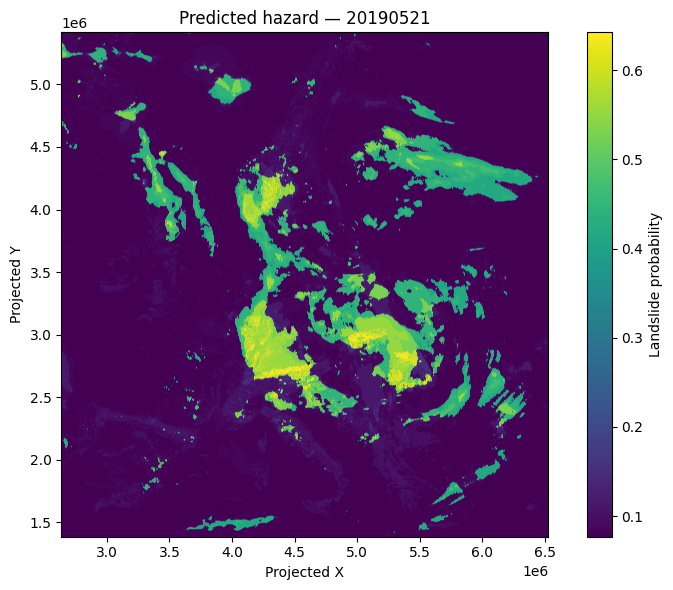

In [7]:
import os, json, numpy as np, rasterio
from rasterio.windows import Window
import xgboost as xgb
import matplotlib.pyplot as plt

# ---- CONFIG ----
DATE = "20190521"  # YYYYMMDD for the day you want to map
BASE = "/content/drive/MyDrive/Project-Landslide/ELSUS"
ELSUS_PATH = f"{BASE}/elsus_v2.asc"  # or .tif
RAIN_DIR   = f"{BASE}/rain_features_TARGET"
OUTDIR     = f"{BASE}/outputs_trial_{DATE}"
MODEL_PATH = f"{OUTDIR}/model.json"
METRICS    = f"{OUTDIR}/metrics.json"

# Output geotiff
HAZ_TIF = os.path.join(OUTDIR, f"hazard_{DATE}.tif")

# ---- LOAD MODEL + FEATURE ORDER ----
with open(METRICS) as f:
    m = json.load(f)
feature_cols = m["features"]  # e.g. ['elsus_class','rain_1d','rain_3d','rain_7d']

bst = xgb.Booster()
bst.load_model(MODEL_PATH)

# ---- OPEN RASTERS (must share grid/CRS/transform/shape) ----
def open_raster(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return rasterio.open(path)

# ELSUS: assumed already coded 1..5 in your file; if not, recode beforehand.
elsus_src = open_raster(ELSUS_PATH)
height, width = elsus_src.height, elsus_src.width
transform = elsus_src.transform
crs = elsus_src.crs

# Build a dict of feature sources keyed by feature name
srcs = {"elsus_class": elsus_src}
for fname in ["rain_1d","rain_3d","rain_7d","rain_anom_7d","rain_p90_7d"]:
    p = os.path.join(RAIN_DIR, f"{fname}_{DATE}.tif")
    if os.path.exists(p):
        srcs[fname] = open_raster(p)

# Ensure all features required by the model are present
missing = [f for f in feature_cols if f not in srcs]
if missing:
    raise RuntimeError(f"Missing raster(s) for features: {missing}")

# ---- CREATE OUTPUT ----
profile = elsus_src.profile.copy()
profile.update(driver="GTiff", dtype="float32", count=1, nodata=np.nan, compress="LZW", predictor=2, tiled=True, blockxsize=512, blockysize=512)
dst = rasterio.open(HAZ_TIF, "w", **profile)

# ---- BLOCK-WISE INFERENCE ----
block = 1024  # adjust if you have more/less RAM
rows = list(range(0, height, block))
cols = list(range(0, width, block))

for r0 in rows:
    for c0 in cols:
        h = min(block, height - r0)
        w = min(block, width - c0)
        win = Window(c0, r0, w, h)

        # Stack features in the correct order
        feats = []
        for f in feature_cols:
            arr = srcs[f].read(1, window=win).astype("float32")
            feats.append(arr)

        # Mask: require all features finite
        stack = np.stack(feats, axis=0)            # (n_feat, h, w)
        valid = np.isfinite(stack).all(axis=0)     # (h, w)

        # Prepare X for prediction
        X = np.zeros((h*w, len(feature_cols)), dtype="float32")
        for j in range(len(feature_cols)):
            X[:, j] = stack[j].reshape(-1)

        # Set invalid pixels to nan (we’ll put nan in output)
        nan_mask_flat = ~np.isfinite(X).all(axis=1)
        # Predict on valid only
        yhat = np.full(h*w, np.nan, dtype="float32")
        if (~nan_mask_flat).any():
            dmat = xgb.DMatrix(X[~nan_mask_flat], feature_names=feature_cols)
            yhat_valid = bst.predict(dmat).astype("float32")
            yhat[~nan_mask_flat] = yhat_valid

        # Reshape back and write
        yhat = yhat.reshape(h, w)
        # Also enforce invalid mask to NaN
        yhat[~valid] = np.nan
        dst.write(yhat, 1, window=win)

dst.close()
for s in srcs.values():
    s.close()

print("Wrote hazard map:", HAZ_TIF)

# ---- QUICKLOOK PLOT ----
with rasterio.open(HAZ_TIF) as src:
    prob = src.read(1)
    t = src.transform

print("Hazard stats (finite pixels):",
      "min=", np.nanmin(prob), "max=", np.nanmax(prob), "mean=", np.nanmean(prob))

plt.figure(figsize=(8,6))
# default colormap; values are 0..1; NaNs will show as blank
plt.imshow(prob, extent=(t.c, t.c + t.a*width, t.f + t.e*height, t.f), origin="upper")
plt.colorbar(label="Landslide probability")
plt.title(f"Predicted hazard — {DATE}")
plt.xlabel("Projected X"); plt.ylabel("Projected Y")
plt.tight_layout()
plt.show()
